In [39]:
import pandas as pd
import numpy as np
trueY=pd.read_csv("result/trueY.txt",header=None)[0]

In [40]:
GBFS_mu10_preds=pd.read_csv("result/GBFS_mu10_preds.txt",header=None)[0]

In [46]:
BT_preds=pd.read_csv("result/BT_preds.txt",header=None)[0]

In [48]:
GBFS_mu50_preds=pd.read_csv("result/GBFS_mu50_preds.txt",header=None)[0]

In [50]:
GBFS_mu0_preds=pd.read_csv("result/GBFS_mu0_preds.txt",header=None)[0]

In [44]:
from sklearn.metrics import roc_auc_score

In [45]:
roc_auc_score(trueY,GBFS_mu10_preds)

0.9440926565926566

In [47]:
roc_auc_score(trueY,BT_preds)

0.9407748032748033

In [49]:
roc_auc_score(trueY,GBFS_mu50_preds)

0.9382335007335006

In [51]:
roc_auc_score(trueY,GBFS_mu0_preds)

0.9449178449178449

In [52]:
from os import listdir
from os.path import isfile, join
filenames = [f for f in listdir("result/") if isfile(join("result/", f))]

In [55]:
AUCs={}
for filename in filenames:
    stem,ext=filename.split(".")
    if ext=="txt" and stem[-5:]=="preds":
        preds=pd.read_csv(f"result/{filename}",header=None)[0]
        AUCs[stem]=roc_auc_score(trueY,preds)




In [57]:
AUCs

{'GBFSt20_mu1000_preds': 0.9406169281169281,
 'GBFSt20_mu200_preds': 0.9389563889563891,
 'GBFS_mu1_preds': 0.9454314079314081,
 'GBFS_mu200_preds': 0.9403493653493654,
 'GBFSt20_mu50_preds': 0.9399706524706525,
 'GBFS_mu50_preds': 0.9382335007335006,
 'GBFS_mu100_preds': 0.938422725922726,
 'GBFSt20_mu10_preds': 0.9415687915687916,
 'GBFS_mu1000_preds': 0.9450661575661576,
 'GBFS_mu0_preds': 0.9449178449178449,
 'GBFS_mu10_preds': 0.9440926565926566,
 'BT_preds': 0.9407748032748033,
 'GBFSt20_mu10000_preds': 0.9401567651567653,
 'GBFSt20_mu1_preds': 0.94253198003198,
 'GBFS_mu10000_preds': 0.9443019443019444,
 'GBFS_mu500_preds': 0.9383589383589382,
 'GBFSt20_mu100_preds': 0.9408739533739533,
 'GBFSt20_mu0_preds': 0.9430501180501181,
 'GBFSt20_mu500_preds': 0.9347014847014848,
 'BTt20_preds': 0.937510125010125}

In [4]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np


In [1]:
filenames_ = [f for f in listdir("result/") if isfile(join("result/", f))]

NameError: name 'listdir' is not defined

In [29]:
top_default=20

In [12]:
topks=pd.read_csv("topk.txt",header=None)[0]

In [32]:
result_path='result_gold_test_in_qa_split/'
aux_path='aux_result_gold_test_in_qa_split/'

In [33]:
filenames_result=listdir(result_path)
filenames_aux=listdir(aux_path)

In [35]:
trueY=pd.read_csv(result_path+"trueY.txt",header=None)[0]

In [40]:
filenames_aux

['GBDTt65_preds.txt',
 'BTt50.bin',
 'BTt55_preds.txt',
 'boosting_rms_GBDTt35.txt',
 'gold_train_in_qa_split_with_vsims_BTt50.attr',
 'gold_train_in_qa_split_with_vsims_BTt35.attr',
 'boosting_rms_GBDTt30.txt',
 'gold_test_in_qa_split.dta',
 'gold_train_in_qa_split_with_vsims_BTt55.attr',
 'bagging_rms_BTt25.txt',
 'BTt25.bin',
 'trueY.txt',
 'GBDTt60_preds.txt',
 'BTt60_preds.txt',
 'preprocess_unused.txt',
 'gold_train_in_qa_split_with_vsims_BTt25.attr',
 'bagging_rms_BTt40.txt',
 'gold_train_in_qa_split_with_vsims_BTt60.attr',
 'bagging_rms_BTt35.txt',
 'gold_train_in_qa_split_with_vsims.dta',
 'gold_train_in_qa_split_with_vsims_GBDTt65.attr',
 'BTt35_preds.txt',
 'nohup1.out',
 'gold_train_in_qa_split_with_vsims_GBDTt25.attr',
 'boosting_rms_GBDTt60.txt',
 'GBDTt25_preds.txt',
 'gold_train_in_qa_split_with_vsims.attr',
 'BTt30.bin',
 'gold_train_in_qa_split_with_vsims_GBDTt30.attr',
 'bagging_rms_BTt60.txt',
 'boosting_rms_GBDTt50.txt',
 'gold_train_in_qa_split_with_vsims_GBDTt60.

In [34]:
filenames_result

['gold_train_in_qa_split_with_vsims_GBFS_mu400.attr',
 'feature_scores_BTt20.txt',
 'log_GBFS_mu2.txt',
 'GBFS_mu12_preds.txt',
 'gold_train_in_qa_split_with_vsims_GBFS_mu120.attr',
 'gold_train_in_qa_split_with_vsims_GBFS_mu5000.attr',
 'log_GBFS_mu1.txt',
 'GBFSt20_mu360_preds.txt',
 'GBFS_mu16_preds.txt',
 'boosting_rms_GBFSt20_mu50000.txt',
 'log_GBFS_mu180.txt',
 'log_GBFS_mu0.txt',
 'GBFSt20_mu20_preds.txt',
 'gold_train_in_qa_split_with_vsims_GBFS_mu200.attr',
 'GBFS_mu340_preds.txt',
 'boosting_rms_GBFSt20_mu10.5.txt',
 'boosting_rms_GBFS_mu60.txt',
 'boosting_rms_GBFS_mu480.txt',
 'boosting_rms_GBFSt20_mu7.txt',
 'boosting_rms_GBFS_mu12.txt',
 'log_GBFS_mu560.txt',
 'GBFS_mu7_preds.txt',
 'log_GBFSt20_mu8.txt',
 'boosting_rms_GBFS_mu3.txt',
 'gold_train_in_qa_split_with_vsims_GBFS_mu70.attr',
 'GBFS_mu5_preds.txt',
 'feature_scores_GBFSt20_mu160.txt',
 'GBFSt20_mu1000_preds.txt',
 'boosting_rms_GBFSt20_mu460.txt',
 'log_GBFS_mu420.txt',
 'boosting_rms_GBFSt20_mu15.txt',
 'GBFS

In [37]:
from sklearn.metrics import roc_auc_score

In [230]:
class Model:
    def __init__(self,name="GBDT",penalty=0,topk=-1,attrN=-1,preds=None):
        self.name=name
        self.pen=penalty
        self.topk=topk
        self.preds=preds
        self.attrN=attrN
        
    def get_AUC(self):
        return roc_auc_score(trueY,self.preds) if self.preds is not None else None
    
    #add some other metrics later
        
        
        

In [231]:
import collections

In [232]:
#store results when go through all files in result folder
mus=collections.defaultdict(dict) # store preds,attrN for different mu without selecting the top ranked feature
mus_t={}  # store preds for different mu with selecting the top ranked feature
BT_preds=None
BTt_default_preds=None
for filename in filenames_result:
    last_dot=filename.rfind(".")
    fname,fext=filename[:last_dot],filename[last_dot+1:]
    if fext=="txt":
        if "_preds" in fname:
            preds=pd.read_csv(result_path+filename,header=None)[0]
            if "_mu" not in fname:
                if "BTt" in fname:
                    BTt_default_preds=preds
                else:
                    BT_preds=preds
            else:
                idx=fname.index("_mu")
                mu=float(fname[idx+3:-6])
                if "GBFSt" in fname:
                    mus_t[mu]=preds
                else:
                    mus[mu]["preds"]=preds
        elif "feature_scores_GBFS_" in fname:
            tmp=pd.read_csv(result_path+filename,header=None)[0][0] # the first line of feature_score reports attrN
            attrN=int(tmp.split()[-1])
            idx=fname.index("_mu")
            mu=float(fname[idx+3:])
            mus[mu]["attrN"]=attrN

In [233]:
#store results when go through all files in aux_result folder
BTt_preds={}
GBDTt_preds={}
for filename in filenames_aux:
    last_dot=filename.rfind(".")
    fname,fext=filename[:last_dot],filename[last_dot+1:]
    if fext=="txt" and "_preds" in fname:
        preds=pd.read_csv(aux_path+filename,header=None)[0]
        if "BTt" in fname:
            topk=int(fname[3:-6])
            BTt_preds[topk]=preds
        else:
            topk=int(fname[5:-6])
            GBDTt_preds[topk]=preds

In [234]:
model_results=[]
# GBFS model
for mu in mus:
    model_results.append(Model(penalty=mu,attrN=mus[mu]["attrN"],preds=mus[mu]["preds"]))
# GBFSt model
for mu in mus_t:
    model_results.append(Model(penalty=mu,topk=top_default,attrN=top_default,preds=mus_t[mu]))
# BT model
model_results.append(Model(name="BT",preds=BT_preds))

# BTt model
model_results.append(Model(name="BT",topk=top_default,attrN=top_default,preds=BTt_default_preds))
for k in BTt_preds:
    model_results.append(Model(name="BT",topk=k,attrN=k,preds=BTt_preds[k]))

# GBDTt model
for k in GBDTt_preds:
    model_results.append(Model(topk=k,attrN=k,preds=GBDTt_preds[k]))  
    
 

In [235]:
import matplotlib.pyplot as plt

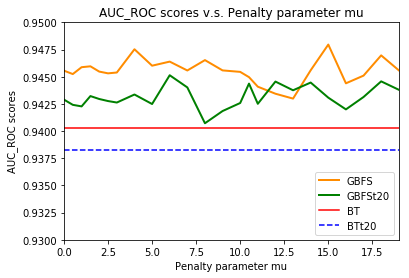

In [259]:
# plot1 AUC v.s. mus for GBFS and GBFSt
plt.figure()
lw = 2
x_axis=sorted(list([ mu for mu in mus.keys() if mu<20]))
y1_axis=[roc_auc_score(trueY,mus[x]["preds"]) for x in x_axis]
y2_axis=[roc_auc_score(trueY,mus_t[x]) for x in x_axis]
plt.plot(x_axis, y1_axis, color='darkorange',
         lw=lw, label='GBFS')
plt.plot(x_axis, y2_axis, color='g',
         lw=lw, label=f'GBFSt{top_default}')
plt.axhline(y=roc_auc_score(trueY,BT_preds), color='r', linestyle='-',label='BT')
plt.axhline(y=roc_auc_score(trueY,BTt_default_preds), color='b', linestyle='--',label=f'BTt{top_default}')
plt.xlim([0.0, max(x_axis)])
plt.ylim([0.93, 0.95])
plt.xlabel('Penalty parameter mu')
plt.ylabel('AUC_ROC scores')
plt.title(f'AUC_ROC scores v.s. Penalty parameter mu')
plt.legend(loc="lower right")
plt.show()






In [262]:
x_axis

[0.0,
 0.5,
 1.0,
 1.5,
 2.0,
 2.5,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 10.5,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0]

In [260]:
max(y2_axis)

0.9451357951357949

In [261]:
min(y2_axis)

0.9407202782202783

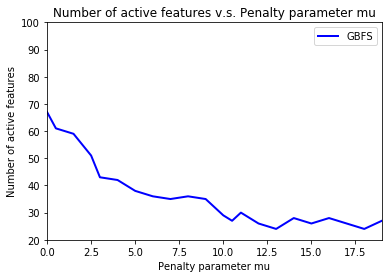

In [238]:
# plot2 attrN v.s. mus for GBFS
plt.figure()
lw = 2
x_axis=sorted(list([ mu for mu in mus.keys() if mu<20]))
y3_axis=[mus[x]["attrN"] for x in x_axis]
plt.plot(x_axis, y3_axis, color='b',
         lw=lw, label='GBFS')
plt.xlim([0.0, max(x_axis)])
plt.ylim([20, 100])
plt.xlabel('Penalty parameter mu')
plt.ylabel('Number of active features')
plt.title('Number of active features v.s. Penalty parameter mu')
plt.legend(loc="upper right")
plt.show()


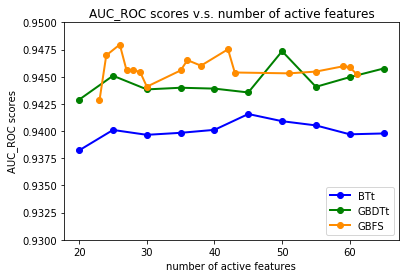

In [243]:
# plot3 AUC_ROC v.s. attrN (for best score with the given attrN for GBFSt)

BTt=collections.defaultdict(int)
GBDTt=collections.defaultdict(int)
GBFS=collections.defaultdict(int)
for model in model_results:
    if model.name=="BT" and model.topk>0:
        BTt[model.attrN]=max(BTt[model.attrN],model.get_AUC())
    elif model.name=="GBDT" and model.pen==0 and model.topk>0 :
        GBDTt[model.attrN]=max(GBDTt[model.attrN],model.get_AUC())
    elif model.name=="GBDT" and 0<model.pen<=20 and model.topk==-1: 
        GBFS[model.attrN]=max(GBFS[model.attrN],model.get_AUC())
        
plt.figure()
lw = 2
x1_axis=sorted(list(BTt.keys()))
y1_axis=[BTt[x] for x in x1_axis]
x2_axis=sorted(list(GBDTt.keys()))
y2_axis=[GBDTt[x] for x in x2_axis]
x3_axis=sorted(list(GBFS.keys()))
y3_axis=[GBFS[x] for x in x3_axis]

plt.plot(x1_axis, y1_axis, color='b',
         lw=lw, label='BTt',marker="o")
plt.plot(x2_axis, y2_axis, color='g',
         lw=lw, label='GBDTt',marker="o")
plt.plot(x3_axis, y3_axis, color='darkorange',
         lw=lw, label='GBFS',marker="o")
plt.ylim([0.93, 0.95])
plt.xlabel('number of active features')
plt.ylabel('AUC_ROC scores')
plt.title(f'AUC_ROC scores v.s. number of active features')
plt.legend(loc="lower right")
plt.show()


In [251]:
max(GBDTt.values())

0.9473490848490848

In [252]:
min(GBDTt.values())

0.9428936303936305

In [249]:
roc_auc_score(trueY,BT_preds)

0.9402504402504402

0.9382292632292634